In [ ]:
# 책에 없지만 정상 동작을 위해 코드 추가
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
!pip install -U tf-agents

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd6

In [ ]:
import gym
gym.envs.registry.all()

env = gym.make('CartPole-v1')
env.seed(42) # 책과 동일한 결과를 위해 코드 추가
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [ ]:
# 책에 없지만 정상 동작을 위해 코드 추가
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible = 0, size = (1400, 900)).start()

In [ ]:
env.render()

True

In [ ]:
img = env.render(mode = "rgb_array")
img.shape # 높이, 너비, 채널 ( 3 = 빨강, 초록, 파랑 )

(400, 600, 3)

In [ ]:
env.action_space

Discrete(2)

In [ ]:
action = 1 # 오른쪽으로 가속
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

In [ ]:
reward

1.0

In [ ]:
done

False

In [ ]:
info

{}

In [ ]:
def basic_policy(obs) :
  angle = obs[2]
  return 0 if angle < 0 else 1

env.seed(42) # 책과 동일한 결과를 위해 코드 추가
totals = []
for episode in range(500) :
  episode_rewards = 0
  obs = env.reset()
  for step in range(200) :
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [ ]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

# 18.4 신경망 정책

In [ ]:
import tensorflow as tf
from tensorflow import keras

n_inputs = 4 # == env.observation_spzce.shape[0]

model = keras.models.Sequential([
                                 keras.layers.Dense(5, activation = "elu",  input_shape = [n_inputs]),
                                 keras.layers.Dense(1, activation = "sigmoid"),
])

# 18.6 정책 그레이디언트

In [ ]:
def play_one_step(env, obs, model, loss_fn) :
  with tf.GradientTape() as tape :
    left_proba = model(obs[np.newaxis])
    action = (tf.random.uniform([1, 1]) > left_proba)

    y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
    loss = tf.reduce_mean(loss_fn(y_target, left_proba))

  grads = tape.gradient(loss, model.trainable_variables)
  obs, reward, done, info = env.step(int(action[0, 0].numpy()))
  return obs, reward, done, grads

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn) :
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes) :
    current_rewards = []
    current_grads = []
    obs = env.reset()
    for step in range(n_max_steps) :
      obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
      current_rewards.append(reward)
      current_grads.append(grads)
      if done:
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)
  return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_factor) :
  discounted = np.array(rewards)
  for step in range(len(rewards) - 2, -1, -1) :
    discounted[step] += discounted[step + 1] * discount_factor
  return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor) :
  all_discounted_rewards = [discount_rewards(rewards, discount_factor)
  for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std  = flat_rewards.std()
  return [(discounted_rewards - reward_mean) / reward_std
          for discounted_rewards in all_discounted_rewards]

In [ ]:
discount_rewards([10, 0, -50], discount_factor = 0.8)

array([-22, -40, -50])

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor = 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [ ]:
optimizer = keras.optimizers.Adam(lr = 0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
# 약 11분 소요
for iteration in range(n_iterations) :
  all_rewards, all_grads = play_multiple_episodes(
      env, n_episodes_per_update, n_max_steps, model, loss_fn)
  all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
  
  all_mean_grads = []
  for var_index in range(len(model.trainable_variables)) :
    mean_grads = tf.reduce_mean(
        [final_reward * all_grads[episode_index][step][var_index]
         for episode_index, final_rewards in enumerate(all_final_rewards)
           for step, final_reward in enumerate(final_rewards)], axis = 0)
    all_mean_grads.append(mean_grads)
  optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

# 18.7 마르코프 결정 과정

In [ ]:
transition_probabilities = [ # shape = [s, a, s']
                            [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
                            [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]], 
                            [None, [0.8, 0.1, 0.1], None]
                            ]

rewards = [ # shape = [s, a, s']
           [[+10, 0, 0], [0, 0, 0], [0, 0, 0,]],
           [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
           [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
           ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

In [ ]:
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions) :
  Q_values[state, actions] = 0.0 # 모든 가능한 행동에 대해서

In [ ]:
gamma = 0.90 # 할인 계수

for iteration in range(50) :
  Q_prev = Q_values.copy()
  for s in range(3) :
    for a in possible_actions[s] :
      Q_values[s, a] = np.sum([
                               transition_probabilities[s][a][sp]
                               * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                               for sp in range(3)])

In [ ]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [ ]:
np.argmax(Q_values, axis = 1)

array([0, 0, 1])

# 18.9 Q-러닝

In [ ]:
def step(state, action) :
  probas = transition_probabilities[state][action]
  next_state = np.random.choice([0, 1, 2], p = probas)
  reward = rewards[state][action][next_state]
  return next_state, reward

In [ ]:
def exploration_policy(state) :
  return np.random.choice(possible_actions[state])

In [ ]:
alpha0 = 0.05 # 초기학습률
decay  = 0.005 # 학습률 감쇠
gamma  = 0.90  # 할인 계수
state  = 0     # 초기 상태

for iteration in range(10000) :
  action = exploration_policy(state)
  next_state, reward = step(state, action)
  next_value = np.max(Q_values[next_state])

  alpha = alpha0 / (1 + iteration * decay)
  Q_values[state, action] *= 1 - alpha
  Q_values[state, action] += alpha * (reward + gamma * next_value)
  state = next_state

# 18.10 심층 Q-러닝 구현하기

In [ ]:
env = gym.make("CartPole-v0")
input_shape = [4] # == env.observation_space.shape
n_outputs   = 2   # == env.action_space.n

model = keras.models.Sequential([
                                 keras.layers.Dense(32, activation = "elu", input_shape = input_shape),
                                 keras.layers.Dense(32, activation = "elu"),
                                 keras.layers.Dense(n_outputs)
])

In [ ]:
def epsilon_greed_policy(state, epsilon = 0) :
  if np.random.rand() < epsilon :
    return np.random.randint(2)
  else :
    Q_values = model.predict(state[np.newaxis])
    return np.argmax(Q_values[0])

In [ ]:
from collections import deque

replay_buffer = deque(maxlen = 2000)

In [ ]:
def sample_experiences(batch_size) :
  indices = np.random.randint(len(replay_buffer), size = batch_size)
  batch = [replay_buffer[index] for index in indices]

  states, actions, rewards, next_states, dones = [
                                                  np.array([experience[field_index] for experience in batch])
                                                  for field_index in range(5)]
  return states, actions, rewards, next_states, dones  

In [ ]:
def play_one_step(env, state, epsilon) :
  action = epsilon_greed_policy(state, epsilon)
  next_state, reward, done, info = env.step(action)
  replay_buffer.append((state, action, reward, next_state, done))
  return next_state, reward, done, info

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr = 1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size) :
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones = experiences

  next_Q_values = model.predict(next_states)
  max_next_Q_values = np.max(next_Q_values, axis = 1)

  target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)
  target_Q_values = target_Q_values.reshape(-1, 1)

  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape :
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims = True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
  
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
# 약 5분 소요
for episode in range(600) :
  obs = env.reset()
  for step in range(200) :
    epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, info = play_one_step(env, obs, epsilon)
    if done :
      break
  if episode > 50 :
    training_step(batch_size)

# 18.11 심층 Q-가치 타깃

## 18.11.1 고정 Q-가치 타깃

In [ ]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
# next_Q_values = target.predict(next_states)
# 책에 없지만 정상 동작을 위해 코드 수정 ( 책의 의도대로 코드 수행 )
def training_step(batch_size) :
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones = experiences

  # next_Q_values = model.predict(next_states)
  next_Q_values = target.predict(next_states)
  max_next_Q_values = np.max(next_Q_values, axis = 1)

  target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)
  target_Q_values = target_Q_values.reshape(-1, 1)

  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape :
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims = True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
  
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
"""
if episode % 50 == 0 :
  target.set_weights(model.get_weights())
"""
# 책에 없지만 정상 동작을 위해 코드 수정 ( 책의 의도대로 코드 수행 ) / 약 3분 소요
for episode in range(600) :
  obs = env.reset()
  for step in range(200) :
    epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, info = play_one_step(env, obs, epsilon)
    if done :
      break
#  if episode > 50 :
#    training_step(batch_size)
  if episode % 50 == 0 :
    target.set_weights(model.get_weights())

## 18.11.2 더블 DQN

In [ ]:
def training_step(batch_size) :
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones = experiences

  next_Q_values = model.predict(next_states)
  best_next_actions = np.argmax(next_Q_values, axis = 1)

  next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
  next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis = 1)

  target_Q_values = (rewards + 
                     (1 - dones) * discount_factor * next_best_Q_values)
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, n_outputs)

  # 책에 없지만 정상동작을 위해 코드 추가( 책의 의도대로 )
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims = True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

## 18.11.4 듀얼링 DQN 

In [ ]:
K = keras.backend
input_states = keras.layers.Input(shape = [4])

hidden1 = keras.layers.Dense(32, activation = "elu")(input_states)
hidden2 = keras.layers.Dense(32, activation = "elu")(hidden1)

state_values   = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)

advantages = raw_advantages - K.max(raw_advantages, axis = 1, keepdims = True)
Q_values = state_values + advantages
model = keras.Model(inputs = [input_states], outputs = [Q_values])

# 18.12 TF-Agents 라이브러리

## 18.12.2 TF-Agents 환경

In [ ]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [ ]:
env.gym

In [ ]:
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [ ]:
#env.step(1) # Fire
env.step(np.array(1)) # Fire # 1 -> np.array(1)

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## 18.12.3 환경 스펙

In [ ]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [ ]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [ ]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [ ]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

## 18.12.4 환경 래퍼와 아타리 전처리

In [ ]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times = 4)

In [ ]:
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers = [lambda env: TimeLimit(env, max_episode_steps = 10000)],
    env_wrappers = [lambda env: ActionRepeat(env, times = 4)],
)

In [ ]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 1  스텝이 = 4 프레임이므로, 108,000개 ALE 프레임
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps = max_episode_steps,
    gym_env_wrappers = [AtariPreprocessing, FrameStack4]
)

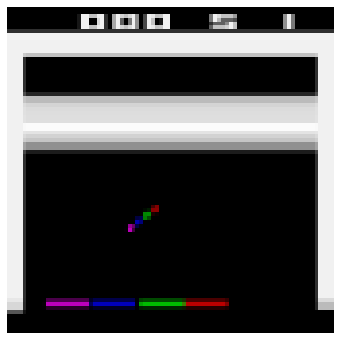

In [ ]:
# 책에 없지만 그래픽 출력을 위한 코드 추가
env.seed(42)
env.reset()
env.step(np.array(1))
for _ in range(4):
  time_step = env.step(np.array(3))

def plot_observation(obs) :
  obs = obs.astype(np.float32)
  img = obs[..., :3]
  current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis = -1), 0.)
  img[..., 0] += current_frame_delta
  img[..., 2] += current_frame_delta
  img = np.clip(img / 150, 0, 1)
  plt.imshow(img)
  plt.axis("off")

import matplotlib.pyplot as plt
plt.figure(figsize = (6, 6))
plot_observation(time_step.observation)
plt.show()

In [ ]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## 18.12.6 심층 Q-네트워크 만들기

In [ ]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params   = [512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),

    preprocessing_layers = preprocessing_layer,
    conv_layer_params = conv_layer_params,
    fc_layer_params = fc_layer_params
)

## 18.12.7 DQN 에이전트 만들기

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # 4 스텝마다 모델을 훈련합니다.
optimizer = keras.optimizers.RMSprop(lr = 2.5e-4, rho = 0.95, momentum = 0.0, 
                                     epsilon = 0.00001, centered = True)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 1.0, # 초기 ε
    decay_steps = 250000 // update_period, #  <=> 1,000,000 ALE 프레임
    end_learning_rate = 0.01) # 마지막 ε

agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network = q_net,
                 optimizer = optimizer,
                 target_update_period = 2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn = keras.losses.Huber(reduction = "none"),
                 gamma = 0.99, # 할인 계수
                 train_step_counter = train_step,
                 epsilon_greedy = lambda: epsilon_fn(train_step)
                 )
agent.initialize()

## 18.12.8 재생 버퍼와 옵저버 만들기

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = tf_env.batch_size,
    max_length = 100000  # 코랩환경에서 정상 동작을 위해 코드 수정 max_length = 1,000,000 -> 100,000
)

In [ ]:
replay_buffer_observer = replay_buffer.add_batch

In [ ]:
class ShowProgress:
  def __init__(self, total) :
    self.counter = 0
    self.total = total

  def __call__(self, trajectory) :
    if not trajectory.is_boundary():
      self.counter += 1
    if self.counter % 100 == 0 :
      print("\r{}/{}".format(self.counter, self.total), end = "")

## 18.12.9 훈련 측정 지표 만들기

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
                 tf_metrics.NumberOfEpisodes(),
                 tf_metrics.EnvironmentSteps(),
                 tf_metrics.AverageReturnMetric(),
                 tf_metrics.AverageEpisodeLengthMetric(),
]

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


## 18.12.10 수집 드라이버 만들기

In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env, 
    agent.collect_policy,
    observers = [replay_buffer_observer] + train_metrics,
    num_steps = update_period # 각 훈련 반복마다 스텝을 4개 수집합니다.
)

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers = [replay_buffer.add_batch, ShowProgress(20000)],
    num_steps = 20000 # <=> 80,000 ALE 프레임
)
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


20000/20000

## 18.12.11 데이터셋 만들기

In [ ]:
trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size = 2, num_steps = 3
)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [ ]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [ ]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [ ]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [ ]:
dataset = replay_buffer.as_dataset(
    sample_batch_size = 64,
    num_steps = 2,
    num_parallel_calls = 3
).prefetch(3)

## 18.12.12 훈련 반복 만들기

In [ ]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [ ]:
def train_agent(n_iterations) :
  time_step = None
  policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
  iterator = iter(dataset)

  for iteration in range(n_iterations) :
    time_step, policy_state = collect_driver.run(time_step, policy_state)
    trajectories, buffer_info = next(iterator)

    train_loss = agent.train(trajectories)
    print("\r{} loss:{:.5f}".format(
        iteration, train_loss.loss.numpy()), end = ""
    )
    if iteration % 1000 == 0 :
      log_metrics(train_metrics)
  

In [ ]:
train_agent(1) # 코랩 환경에서 정상동작을 위해 10,000,000 -> 1 로 수정

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


0 loss:0.00742